# SCRAPPER 

In [1]:
import re
import csv
from getpass import getpass
from time import sleep
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import NoSuchElementException
from msedge.selenium_tools import Edge, EdgeOptions

In [2]:
def get_tweet_data(card):
    """Extract data from tweet card"""
    username = card.find_element_by_xpath('.//span').text
    try:
        handle = card.find_element_by_xpath('.//span[contains(text(), "@")]').text
    except NoSuchElementException:
        return
    
    try:
        postdate = card.find_element_by_xpath('.//time').get_attribute('datetime')
    except NoSuchElementException:
        return
    
    comment = card.find_element_by_xpath('.//div[2]/div[2]/div[1]').text
    responding = card.find_element_by_xpath('.//div[2]/div[2]/div[2]').text
    text = comment + responding
    reply_cnt = card.find_element_by_xpath('.//div[@data-testid="reply"]').text
    retweet_cnt = card.find_element_by_xpath('.//div[@data-testid="retweet"]').text
    like_cnt = card.find_element_by_xpath('.//div[@data-testid="like"]').text
    
    tweet = (username, handle, postdate, text, reply_cnt, retweet_cnt, like_cnt)
    return tweet
    
options = EdgeOptions()
options.use_chromium = True
driver = Edge(options=options)

driver.get('https://www.twitter.com/login')



In [3]:
# find search input and search for term
search_input = driver.find_element_by_xpath('//input[@aria-label="Search query"]')
search_input.send_keys('Alberto Fernandez')
search_input.send_keys(Keys.RETURN)

In [4]:
click = driver.find_element_by_xpath('//*[@id="react-root"]/div/div/div[2]/main/div/div/div/div/div/div[2]/div/div/section/div/div/div[3]/div/div/div/div[2]/div[1]/div[1]/a')
click.click()

driver.find_element_by_link_text('Tweets').click()


In [5]:
# get all tweets on the page
data = []
tweet_ids = set()
last_position = driver.execute_script("return window.pageYOffset;")
scrolling = True

while scrolling:
    page_cards = driver.find_elements_by_xpath('//article[@data-testid="tweet"]')
    for card in page_cards:
        tweet = get_tweet_data(card)
        if tweet:
            tweet_id = ''.join(tweet)
            if tweet_id not in tweet_ids:
                tweet_ids.add(tweet_id)
                data.append(tweet)
            
    scroll_attempt = 0
    while True:
        # check scroll position
        driver.execute_script('window.scrollTo(0, document.body.scrollHeight);')
        sleep(2)
        curr_position = driver.execute_script("return window.pageYOffset;")
        if last_position == curr_position:
            scroll_attempt += 1
            
            # end of scroll region
            if scroll_attempt >= 3:
                scrolling = False
                break
            else:
                sleep(2) # attempt another scroll
        else:
            last_position = curr_position
            break

# close the web driver
driver.close()


In [12]:
len(data)

301

In [13]:
with open('alberto2_tweets.csv', 'w', newline='', encoding='utf-8') as f:
    header = ['UserName', 'Handle', 'Timestamp', 'Text', 'Comments', 'Likes', 'Retweets']
    writer = csv.writer(f)
    writer.writerow(header)
    writer.writerows(data)

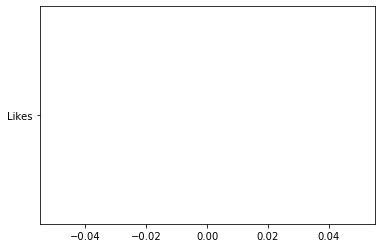

In [6]:
import matplotlib.pyplot as plt
plt.plot('Likes')

In [58]:
['Likes']

['Likes']